# Supermarket Shopping 

##### Names and Matriculation Number (Group 4, Submitted on: 11/4/2025)
Aw Shao Yang       U2323206F

Poh Jia Yong       U2323306C

## Introduction
In this notebook, we’ll use a simple graph model to represent a supermarket layout and explore how to find the shortest path between items on a shopping list. By treating aisles and sections as nodes connected by edges, we can apply basic graph-based algorithms to find the most efficient paths possible. The difference between this and normal single node path finding is that the agent starts from a designated entrance and he  will be given a list of objects such as

['Chicken', 'Beef', 'Apple', 'Deli']

He is required to find the shortest path to obtain all of these items and head to the exit after that. It is more complex than single 1 to 1 path finding as the order of items collected can definitely affect the outcome of each run. Another thing is that we have decided to make our graph bidirectional instead of unidirectional, hence allowing for 2 way movements in some algorithms


At the end we will compare the performance of all 7 search algorithms taught in this mod to see the effectiveness of each of them on this problem

The below libraries have been important to aid us in our path finding developments 

- NetworkX: Network X will allow us to visualise our node diagram much easier

- Pandas: Used for some data processing to generate coordinates for graph for heuristics later on

- collection: For quick datastructures like queue, stack and heap

In [5]:
from collections import deque
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random
random.seed(42)

And below we have a our base datastructure for this lab. We have created the following 
- Node: containing info on its label and edges

- Edge: Edge that referes to a src and destination node along with its weight

- Graph: A simple graph object that is used to add nodes and edges

In [6]:

# Each node contains a label, optional coordinates and its connected edges
class Node:
    def __init__(self, label, pos=None):
        self.label = label
        self.edges = []
        self.pos = pos

    def __repr__(self):
        return f"Node({self.label})"

# Each edge has a source dest and weight
class Edge:
    def __init__(self, src, dest, weight=1):
        self.src = src
        self.dest = dest
        self.weight = weight

    def __repr__(self):
        return f"Edge({self.src.label} -> {self.dest.label}, weight={self.weight})"

# Graph contains nodes and edges
class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = []

    # Adds a node to the graph
    def _add_node(self, node_label, node_pos=None):
        if node_label not in self.nodes:
            self.nodes[node_label] = Node(node_label, node_pos)

    # Adds edges to the graph
    def _add_edge(self, src_label, dest_label, weight, src_pos=None, dest_pos=None):
        
        # Check for presence of node to add
        if src_label not in self.nodes:
            self._add_node(src_label, src_pos)
        if dest_label not in self.nodes:
            self._add_node(dest_label, dest_pos)

        # Add the edge node as well as update each node to add edge
        src_node = self.nodes[src_label]
        dest_node = self.nodes[dest_label]

        edge = Edge(src_node, dest_node, weight)
        src_node.edges.append(edge)
        dest_node.edges.append(edge)
        self.edges.append(edge)        

## Graph Data Handling
Below we have extracted our graph edges, which shows us the source destination and weight. We decided on using a pandas df to do so as there are some processes to be done

In [7]:
csv_data = "graph_data.csv"

Run inplace of no csv file due to submission only requiring notebook

In [8]:
from io import StringIO

# Your CSV data as a string
csv_data = """Source,Dest,Weight
Entrance,Apples,22
Entrance,Pears,20
Entrance,Bananas,10
Pears,Oranges,20
Pears,Apples,6
Apples,Bananas,5
Bananas,Cabbages,19
Oranges,Cabbages,16
Cabbages,Exit,9
Oranges,Beansprouts,7
Oranges,Deli,14
Beansprouts,Exit,10
Deli,Beansprouts,28
Deli,Chicken,9
Chicken,Beef,16
Beef,Pork,31
Beef,Milk,15
Milk,Pork,17
Pork,Exit,20
Milk,Exit,50"""


In [9]:
# Convert to a pandas DataFrame
graph_df = pd.read_csv(StringIO(csv_data))
print(graph_df.shape)
graph_df.head(3)

(20, 3)


,Source,Dest,Weight
0,Entrance,Apples,22
1,Entrance,Pears,20
2,Entrance,Bananas,10


### Bidirection

To make our graph bidirectional, we need to introduce the edges for both ways, hene we created a separate df that reverses the source and dest and merged them together

In [10]:
reverse_df = pd.DataFrame(
    {
        "Source": graph_df['Dest'],
        "Dest": graph_df['Source'],
        "Weight": graph_df['Weight']
    }
)

bi_graph = pd.concat([graph_df, reverse_df])
print(bi_graph.shape)
bi_graph.head(3)

(40, 3)


,Source,Dest,Weight
0,Entrance,Apples,22
1,Entrance,Pears,20
2,Entrance,Bananas,10


### Coordinate Generation
To create a plot for this graph, we have decided to generate some coordinates using network x to visualise it later. Although we do not use the coords for anything besides that in this study, it may actually be useful for heuristics if we wanted to like in A star

In [11]:
G = nx.Graph()

for index, row in bi_graph.iterrows():
    G.add_edge(row['Source'], row['Dest'], weight=row['Weight'])
pos_dict = nx.spring_layout(G, k=2, scale=0.5,seed=42)
pos_dict

{'Entrance': array([0.0114853 , 0.47836766]),
 'Apples': array([0.16113557, 0.41214147]),
 'Pears': array([-0.02916793,  0.20615421]),
 'Bananas': array([-0.21045256,  0.47520089]),
 'Oranges': array([-0.20187832,  0.07947851]),
 'Cabbages': array([-0.18700794,  0.2491406 ]),
 'Exit': array([ 0.13218501, -0.09287119]),
 'Beansprouts': array([-0.17406169, -0.18036549]),
 'Deli': array([-0.28411291, -0.25695695]),
 'Chicken': array([-0.01467946, -0.5       ]),
 'Beef': array([ 0.24927086, -0.43544373]),
 'Pork': array([ 0.24894016, -0.27573732]),
 'Milk': array([ 0.2983439 , -0.15910866])}

The network x graph produced some coordinates for us in the form of a dictionary, it would be easy to look up later for the respective coordinates needed 

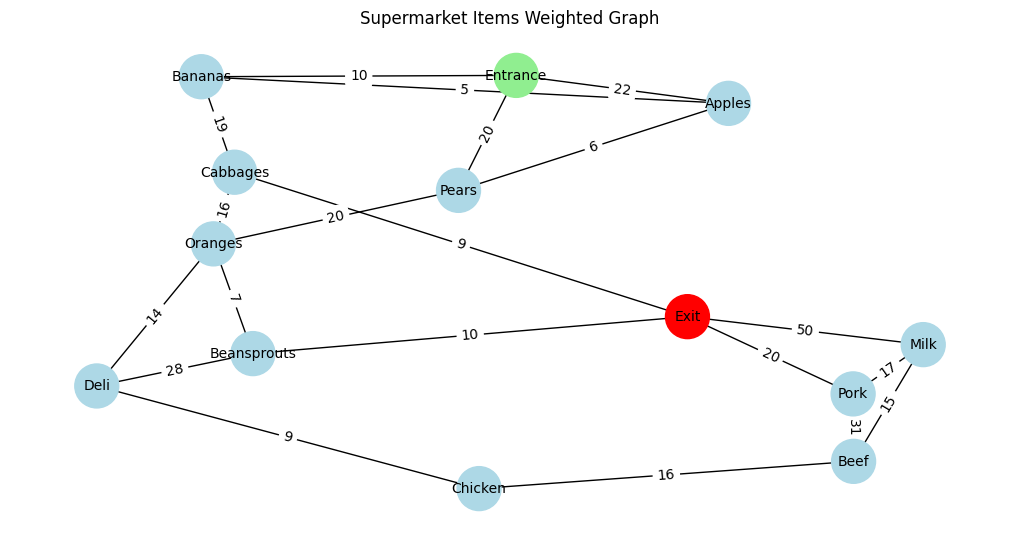

In [12]:
# Define node colors for entrance and exit, else just set blue
node_colors = []
for node in G.nodes:
    if node == "Entrance":
        node_colors.append("lightgreen")  
    elif node == "Exit":
        node_colors.append("red")  
    else:
        node_colors.append("lightblue")  

# Plot nodes and edges
plt.figure(figsize=(10, 5))
nx.draw(G, pos_dict, with_labels=True, node_color=node_colors, node_size=1000, font_size=10)
weights = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos_dict, edge_labels=weights)

# Display the graph
plt.title("Supermarket Items Weighted Graph")
plt.show()


Below we can see the graph generated by network x. Network x uses a force-directed algorithm that simulates attractive and repulsive forces when generating the coordinates, we used a seed to make sure the generated coords are consistent. 

Although some of the weights actually do not correspond to the line distance, we believe that it can still be an appropriate heuristic as we just need a general coordinate sense of things that are closer or further

## Graph Integration

We have also decided to integrate all of this to our graph object under a new class

In [13]:
class GraphX(Graph):

    def __init__(self):
        super().__init__()
        self.pos_dict = None
        self.G = nx.Graph()

    def createFromDf(self, df):
        self.generateCoords(df)

        for index, row in bi_graph.iterrows():
            src = row['Source']
            dest = row['Dest']
            self._add_edge(src, dest, row['Weight'], self.pos_dict[src], self.pos_dict[dest])
                

    def generateCoords(self, df):
        for index, row in df.iterrows():
            self.G.add_edge(row['Source'], row['Dest'], weight=row['Weight'])
        pos_dict = nx.spring_layout(self.G, k=2, scale=0.5,seed=42)
        self.pos_dict = pos_dict
        

    def showGraph(self):
        # Define node colors for entrance and exit, else just set blue
        node_colors = []
        for node in self.G.nodes:
            if node == "Entrance":
                node_colors.append("lightgreen")  
            elif node == "Exit":
                node_colors.append("red")  
            else:
                node_colors.append("lightblue")  

        # Plot nodes and edges
        plt.figure(figsize=(10, 5))
        nx.draw(self.G, self.pos_dict, with_labels=True, node_color=node_colors, node_size=1000, font_size=10)
        weights = nx.get_edge_attributes(self.G, 'weight')
        nx.draw_networkx_edge_labels(self.G, self.pos_dict, edge_labels=weights)

        # Display the graph
        plt.title("Supermarket Items Weighted Graph")
        plt.show()
        

## Our Offical Graph generation 

We have now successfully built a graph that is able to generate its nodes and edges from a df, along with coord generation and some visualisation with the assistance of network x.

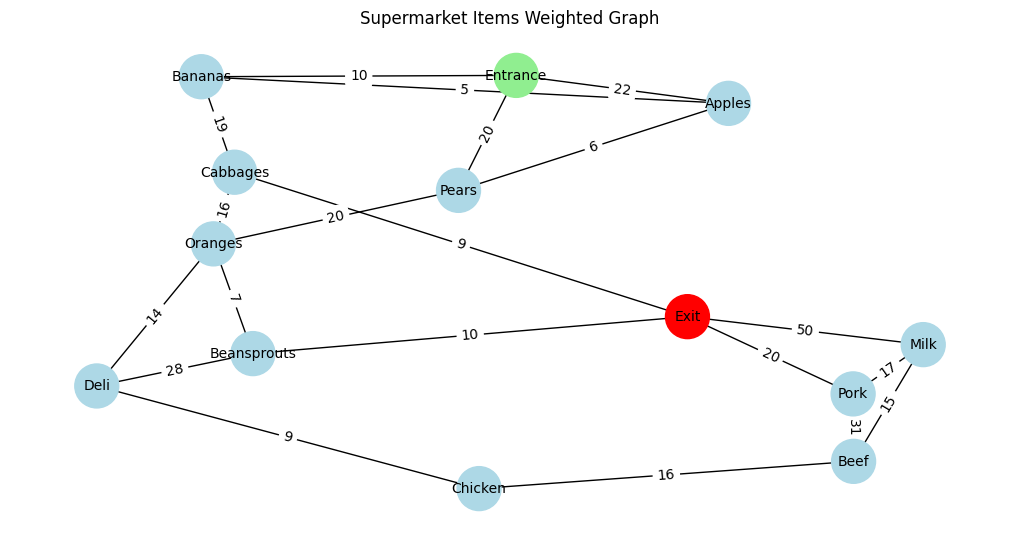

In [14]:
graph = GraphX()

graph.createFromDf(bi_graph)
graph.showGraph()

## Algorithm Creation

We can now proceed on with the algorithm creations.
We will create new inherited graphs per algorithm, i.e. GraphXBFS, GraphXDFS etc...

### Breath First Search
In a breath first search algorithm, we will typically search all nodes within a specific level before proceeding to the next level

<img src="images/Pseudo-Code-for-Breadth-First-Search.png" height=400/>

Due to our circumstance, these are the things we need to ensure when implementing our BFS alg

1. Graph is used instead of tree, hence node visited system must be established to prevent infinite loop

2. Search alg will not care about weight, only refers to nodes traversed as a gauge of best path (traditional BFS)

3. Multi state handling may be required to allow for tracking of item cart and prevention of getting stuck

In [15]:
class GraphXBFS(GraphX):
    def bfs(self, start, end, items_needed={}):
        # Explore queue
        queue = deque()

        # States visited
        visited = set()


        # Create Starting point (My state, Where I am)
        initial_state = (start, frozenset())
        queue.append((initial_state, [start])) 
        visited.add(initial_state)

        state_count = 0
        while queue:
            state_count += 1
            # Extract my current state and position
            (current_label, collected), path = queue.popleft()

            # If the item is smthing I need then pick up
            if current_label in items_needed:
                collected = collected | {current_label}

            if current_label == end and collected == items_needed:
                return path, state_count


            current_node  = self.nodes[current_label]
            
            for edge in current_node.edges:
                neighbor = edge.dest if edge.src.label == current_label else edge.src
                new_state = (neighbor.label, collected)

                if new_state not in visited:
                    visited.add(new_state)
                    queue.append((new_state, path + [neighbor.label]))

        print("No Path found")
        return None, state_count

    def backtrackCost(self, path):
        total_weight = 0

        for i in range(len(path) - 1):
            current = self.nodes[path[i]]
            next_label = path[i + 1]

            # Look for the edge connecting current to next
            for edge in current.edges:
                neighbor = edge.dest if edge.src.label == current.label else edge.src
                if neighbor.label == next_label:
                    total_weight += edge.weight
                    break

                
        return total_weight

In [16]:
graph = GraphXBFS()
items_needed={'Oranges', 'Deli', 'Pork'}
graph.createFromDf(bi_graph)
result, state_count= graph.bfs('Entrance', 'Exit', items_needed=items_needed)
print("Final Path to collect:", items_needed, f'\n{result}', "with a weight of:", graph.backtrackCost(result)) 
print("Total states checked", state_count)

Final Path to collect: {'Deli', 'Oranges', 'Pork'} 
['Entrance', 'Pears', 'Oranges', 'Deli', 'Beansprouts', 'Exit', 'Pork', 'Exit'] with a weight of: 132
Total states checked 59


With this we see that BFS managed to score a weight of 132 which is not bad, and also shows some intelligent bidirectional path finding as it moves back and forth the same locations to efficiently collect athe item and reach the exit

### Depth first search 

Next we decided to try depth first search for path finding


- Uses a stack (LIFO) to explore deeper paths first i.e. branch by branch
- Applies the same multi state formating from BFS to be able to handle basket items and bidirectional/repeat movement
- Returns the first branch that fulfills our requirements which is to have the basket of items and reaching the exit


- For this we think that the algorithm will find a path that is pretty expensive as our problem case is a graph diagram with a lot of state possibilites, making it run in loops and visiting many things

In [17]:
class GraphXDFS(GraphX):
    def dfs(self, start, end, items_needed=set()):
        stack = []
        visited = set()

        # (cost_so_far, (current_label, collected_items), path)
        initial_state = (start, frozenset())
        stack.append((0, initial_state, [start]))
        state_count = 0

        while stack:
            state_count += 1
            cost_so_far, (current_label, collected), path = stack.pop()

            # Collect item if needed
            if current_label in items_needed:
                collected = collected | {current_label}

            # Goal check
            if current_label == end and collected == items_needed:
                return path, cost_so_far, state_count

            # Avoid revisiting exact same state
            state = (current_label, collected)
            if state in visited:
                continue
            visited.add(state)

            current_node = self.nodes[current_label]

            for edge in reversed(current_node.edges):  
                neighbor = edge.dest if edge.src.label == current_label else edge.src
                new_state = (neighbor.label, collected)
                new_cost = cost_so_far + edge.weight

                stack.append((new_cost, new_state, path + [neighbor.label]))

        print("No path found.")
        return None, None, state_count


In [18]:
graph = GraphXDFS()
items_needed={'Oranges', 'Deli', 'Pork'}
graph.createFromDf(bi_graph)
result, cost_so_far,state_count= graph.dfs('Entrance', 'Exit', items_needed=items_needed)
print("Final Path to collect:", items_needed, f'\n{result}', "with a weight of:", cost_so_far) 
print("Total states checked", state_count)

Final Path to collect: {'Deli', 'Oranges', 'Pork'} 
['Entrance', 'Apples', 'Pears', 'Oranges', 'Pears', 'Entrance', 'Apples', 'Bananas', 'Cabbages', 'Exit', 'Beansprouts', 'Deli', 'Oranges', 'Pears', 'Entrance', 'Apples', 'Bananas', 'Cabbages', 'Exit', 'Pork', 'Beef', 'Chicken', 'Deli', 'Oranges', 'Pears', 'Entrance', 'Apples', 'Bananas', 'Cabbages', 'Exit'] with a weight of: 475
Total states checked 61


Here we see that the DFS algorithm did worse than BFS as despite the states explored being similar to DFS, the weight of the final path unfortunately 3 times of that of BFS due to it looping around the store over and over

### Uniform Cost Search

This is a Uniform Cost Search (UCS) adapted for our multi-goal, item-collection problem in a graph. It finds the lowest-cost path from a start node to a goal node while collecting a specific set of items.

- This algorithm determines the most efficient way to collect all required items and reach the goal by expanding the search space into multiple distinct states, each defined by the current node and the set of items collected so far. 

- By allowing the same node to be revisited with different collected sets, the algorithm explores all meaningful combinations of pickup sequences.

- Different from normal uniform cost search algorithms, ours does not just look at the weighted cummulative path but also the cumulative weighted path for specific order of item collection

In [19]:
import heapq

class GraphXUCS(GraphX):
    def ucs(self, start, end, items_needed=set()):
        queue = []
        visited = set()
        seen_costs = {}  # Keeps track of the cheapest cost to each (node, collected) state

        initial_state = (start, frozenset())
        heapq.heappush(queue, (0, initial_state, [start]))  # (cost, state, path)
        seen_costs[initial_state] = 0

        state_count = 0
        while queue:
            state_count += 1
            cost_so_far, (current_label, collected), path = heapq.heappop(queue)

            # Skip if we already saw this state at a lower cost
            if cost_so_far > seen_costs.get((current_label, collected), float('inf')):
                continue

            # Pick up item if needed
            if current_label in items_needed:
                collected = collected | {current_label}

            # Goal check
            if current_label == end and collected == items_needed:
                return path, cost_so_far, state_count

            current_node = self.nodes[current_label]

            for edge in current_node.edges:
                neighbor = edge.dest if edge.src.label == current_label else edge.src
                new_state = (neighbor.label, collected)
                new_cost = cost_so_far + edge.weight

                # Only explore this state if it's new or found with a cheaper cost
                if new_state not in seen_costs or new_cost < seen_costs[new_state]:
                    seen_costs[new_state] = new_cost
                    heapq.heappush(queue, (new_cost, new_state, path + [neighbor.label]))

        print("No path found.")
        return None, None, state_count


In [20]:
graph = GraphXUCS()
items_needed={'Oranges', 'Deli', 'Pork'}
graph.createFromDf(bi_graph)
result, cost_so_far,state_count= graph.ucs('Entrance', 'Exit', items_needed=items_needed)
print("Final Path to collect:", items_needed, f'\n{result}', "with a weight of:", cost_so_far) 
print("Total states checked", state_count)

Final Path to collect: {'Deli', 'Oranges', 'Pork'} 
['Entrance', 'Pears', 'Oranges', 'Deli', 'Oranges', 'Beansprouts', 'Exit', 'Pork', 'Exit'] with a weight of: 125
Total states checked 84


And finally  we see that the states explored were a bit more but it managed to obtain a weight of 125 which is likely the most optimal path of this graph


### Final Results

| Algorithm | Total Weighted Path | States Explored |
|-----------|----------------------|------------------|
| UCS       | 125                  | 84               |
| BFS       | 132                  | 59        |
| DFS       | 475                 |   61            |


From our results above, we see that UCS has been deemed to find the most optimal path, as compared to BFS and DFS, however we also notice that UCS has explored more states, making its time complexity longer as compared to the other 2. DFS performed the worst giving a heaviliy weighted path of 475 but explored little states. This is likely due to how our graph is closed and hence causing it to loop on the same branch till it fulfills the end state